# REGRESI FULL CONNECTED NN

# Import Library

Menggunakan numpy dan pandas untuk memproses dataset, matplotlib dan seaborn untuk visualisasi data, dan Keras untuk mengimplementasikan jaringan saraf (NN). Selain itu, menggunakan Sklearn untuk deteksi outlier dan penskalaan dari dataset.

In [45]:
!pip install keras-tuner --upgrade
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.preprocessing import StandardScaler # Standardization
from sklearn.ensemble import IsolationForest # Outlier Detection
from keras.models import Sequential # Sequential Neural Network
from keras.layers import Dense
from keras.callbacks import EarlyStopping # Early Stopping Callback
from tensorflow.keras.optimizers import Adam # Optimizer
from kerastuner.tuners import RandomSearch # HyperParameter Tuning
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore') # To ignore warnings.

# Memuat Dataset

Menggunakan Dataset dari Boston Housing Price

In [9]:
train = pd.read_csv('house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('house-prices-advanced-regression-techniques/test.csv')
y = train['SalePrice'].values
data = pd.concat([train,test],axis=0,sort=False)
data.drop(['SalePrice'],axis=1,inplace=True)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


# Analisis dan Imputasi Nilai yang Hilang

Pertama-tama kita akan melihat semua fitur dengan nilai yang hilang. Ini akan mencakup data dari data pelatihan dan pengujian.
Ada total 33 fitur yang memiliki nilai yang hilang. Meskipun di beberapa fitur teratas dalam hal persentase nilai yang hilang seperti PoolQC, nilai yang hilang menunjukkan bahwa rumah tidak memiliki fitur tersebut (dalam hal ini rumah tidak memiliki kolam) yang terlihat dari Area Kolam fitur yang menunjukkan nilai 0 sesuai dengan semua nilai yang hilang dari fitur PoolQC. 

In [10]:
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending = False)
NAN_col = list(missing_values.to_dict().keys())
missing_values_data = pd.DataFrame(missing_values)
missing_values_data.reset_index(level=0, inplace=True)
missing_values_data.columns = ['Feature','Number of Missing Values']
missing_values_data['Percentage of Missing Values'] = (100.0*missing_values_data['Number of Missing Values'])/len(data)
missing_values_data

,Feature,Number of Missing Values,Percentage of Missing Values
0,PoolQC,2909,99.657417
1,MiscFeature,2814,96.402878
2,Alley,2721,93.216855
3,Fence,2348,80.438506
4,FireplaceQu,1420,48.646797
5,LotFrontage,486,16.649538
6,GarageFinish,159,5.447071
7,GarageQual,159,5.447071
8,GarageCond,159,5.447071
9,GarageYrBlt,159,5.447071


In [11]:
data['BsmtFinSF1'].fillna(0, inplace=True)
data['BsmtFinSF2'].fillna(0, inplace=True)
data['TotalBsmtSF'].fillna(0, inplace=True)
data['BsmtUnfSF'].fillna(0, inplace=True)
data['Electrical'].fillna('FuseA',inplace = True)
data['KitchenQual'].fillna('TA',inplace=True)
data['LotFrontage'].fillna(data.groupby('1stFlrSF')['LotFrontage'].transform('mean'),inplace=True)
data['LotFrontage'].interpolate(method='linear',inplace=True)
data['MasVnrArea'].fillna(data.groupby('MasVnrType')['MasVnrArea'].transform('mean'),inplace=True)
data['MasVnrArea'].interpolate(method='linear',inplace=True)

In [12]:
for col in NAN_col:
    data_type = data[col].dtype
    if data_type == 'object':
        data[col].fillna('NA',inplace=True)
    else:
        data[col].fillna(data[col].mean(),inplace=True)

# Menambahkan Fitur Baru
Setelah memahami data secara menyeluruh, kemudian membuat beberapa fitur baru dengan cara menggabungkan fitur 

In [13]:
data['Total_Square_Feet'] = (data['BsmtFinSF1'] + data['BsmtFinSF2'] + data['1stFlrSF'] + data['2ndFlrSF'] + data['TotalBsmtSF'])

data['Total_Bath'] = (data['FullBath'] + (0.5 * data['HalfBath']) + data['BsmtFullBath'] + (0.5 * data['BsmtHalfBath']))

data['Total_Porch_Area'] = (data['OpenPorchSF'] + data['3SsnPorch'] + data['EnclosedPorch'] + data['ScreenPorch'] + data['WoodDeckSF'])

data['SqFtPerRoom'] = data['GrLivArea'] / (data['TotRmsAbvGrd'] + data['FullBath'] + data['HalfBath'] + data['KitchenAbvGr'])

# One hot encoding dari Fitur Kategori

Pertama-tama kita akan melihat distribusi fitur antara numerik dan kategorikal

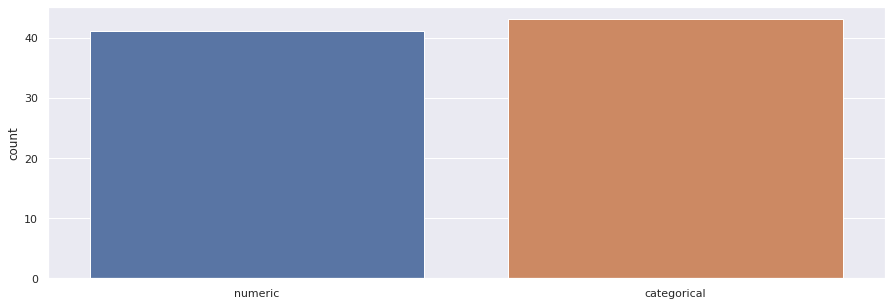

In [14]:
column_data_type = []
for col in data.columns:
    data_type = data[col].dtype
    if data[col].dtype in ['int64','float64']:
        column_data_type.append('numeric')
    else:
        column_data_type.append('categorical')
plt.figure(figsize=(15,5))
sns.countplot(x=column_data_type)
plt.show()

Di sini seperti yang kita lihat bahwa jumlah fitur kategoris sebenarnya melebihi jumlah fitur numerik yang menunjukkan betapa pentingnya fitur ini. Di sini kami telah memilih One hot encoding untuk mengubah fitur kategorikal ini menjadi numerik.

In [15]:
data = pd.get_dummies(data)

Setelah operasi ini, 80 fitur asli telah diperluas menjadi 314 fitur. Pada dasarnya, setiap label fitur kategoris berubah menjadi fitur baru dengan nilai biner (1 untuk sekarang dan 0 untuk tidak ada). Sekarang kita akan membagi data gabungan menjadi data pelatihan dan pengujian untuk melakukan beberapa analisis eksplorasi pada data pelatihan.

In [16]:
train = data[:1460].copy()
test = data[1460:].copy()
train['SalePrice'] = y

# Analisis Data Eksplorasi & Deteksi Pencilan

Pertama-tama kita akan mengekstrak fitur teratas dari kumpulan data pelatihan yang memiliki korelasi tertinggi dengan harga jual

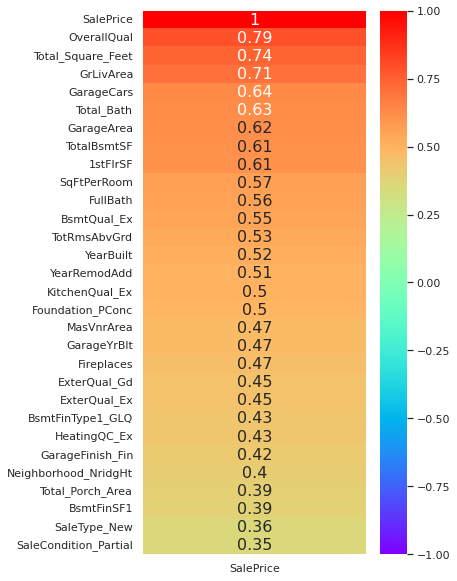

In [17]:
top_features = train.corr()[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(30)
plt.figure(figsize=(5,10))
sns.heatmap(top_features,cmap='rainbow',annot=True,annot_kws={"size": 16},vmin=-1)

Setelah mengekstrak 30 fitur teratas yang memiliki korelasi positif tertinggi dengan SalePrice dalam urutan menurun. Sekarang kita akan memplot beberapa fitur ini terhadap SalePrice untuk menemukan outlier dalam dataset.

In [18]:
def plot_data(col, discrete=False):
    if discrete:
        fig, ax = plt.subplots(1,2,figsize=(14,6))
        sns.stripplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.countplot(train[col], ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')
    else:
        fig, ax = plt.subplots(1,2,figsize=(12,6))
        sns.scatterplot(x=col, y='SalePrice', data=train, ax=ax[0])
        sns.distplot(train[col], kde=False, ax=ax[1])
        fig.suptitle(str(col) + ' Analysis')

Ini adalah fungsi plot yang akan kita gunakan untuk memplot grafik berbagai fitur

# Kualitas Keseluruhan

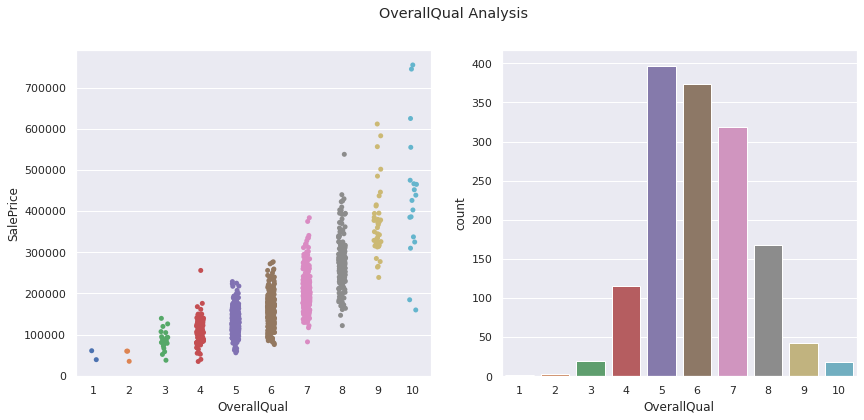

In [19]:
plot_data('OverallQual',True)

Terlihat ada dua outlier dengan 10 kualitas keseluruhan dan harga jual kurang dari 200000

In [20]:
train = train.drop(train[(train['OverallQual'] == 10) & (train['SalePrice'] < 200000)].index)

Jadi kita hapus outlier ini dari dataset. Sekarang kita lanjutkan untuk menganalisis fitur lain

# Total_Square_Feet

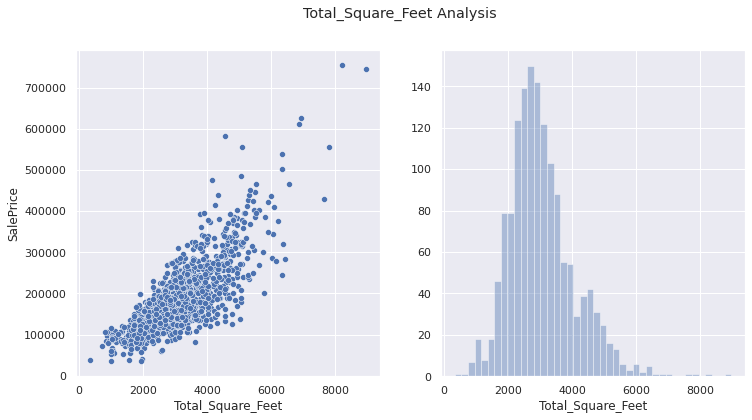

In [21]:
plot_data('Total_Square_Feet')

Terlihat distribusi yang kurang lebih tepat tanpa outlier sama sekali

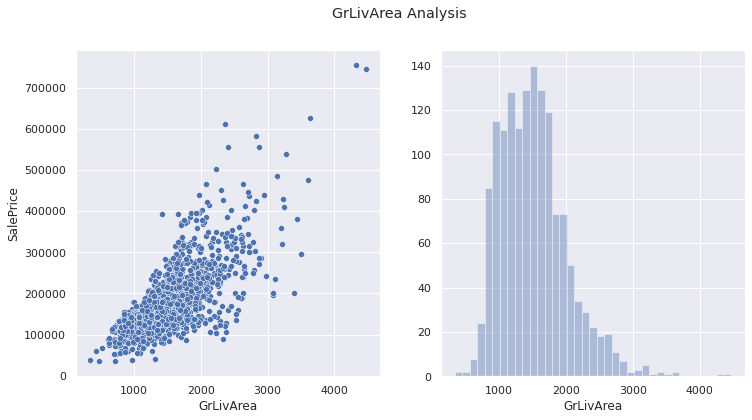

In [22]:
plot_data('GrLivArea')

Sekali lagi tidak ada outlier yang bisa dihilangkan

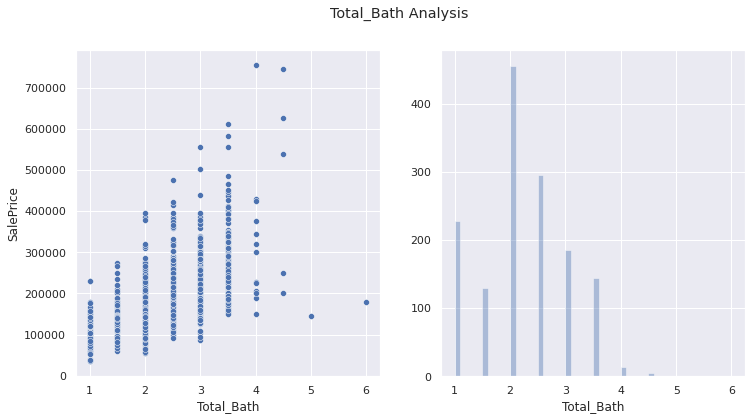

In [23]:
plot_data('Total_Bath')

Di sini kita melihat dua outlier yang memiliki Total_Bath lebih dari 4 tetapi dengan harga jual kurang dari 200000

In [24]:
train = train.drop(train[(train['Total_Bath'] > 4) & (train['SalePrice'] < 200000)].index)

Jadi kita hapus outlier ini

# TotalBsmtSF

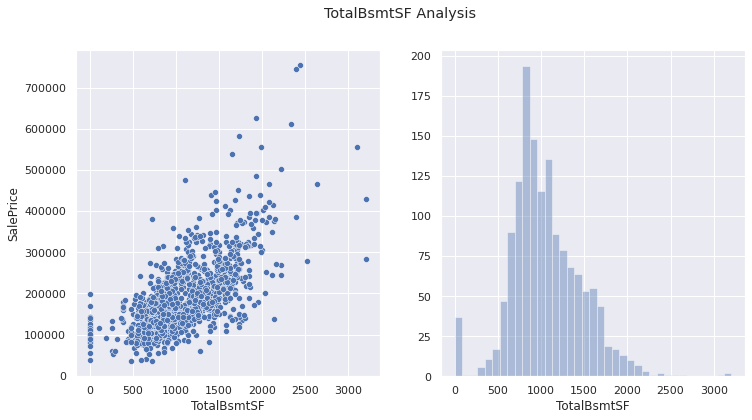

In [25]:
plot_data('TotalBsmtSF')

Di sini juga kita melihat 1 outlier yang jelas yang memiliki TotalBsmtSF lebih dari 3000 tetapi harga jual kurang dari 300000.

In [26]:
train = train.drop(train[(train['TotalBsmtSF'] > 3000) & (train['SalePrice'] < 400000)].index)

In [27]:
train.reset_index() # To reset the index

,index,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,0,1,60,65.0,8450,7,5,2003,2003,196.0,...,0,0,1,0,0,0,0,1,0,208500
1,1,2,20,80.0,9600,6,8,1976,1976,0.0,...,0,0,1,0,0,0,0,1,0,181500
2,2,3,60,68.0,11250,7,5,2001,2002,162.0,...,0,0,1,0,0,0,0,1,0,223500
3,3,4,70,60.0,9550,7,5,1915,1970,0.0,...,0,0,1,1,0,0,0,0,0,140000
4,4,5,60,84.0,14260,8,5,2000,2000,350.0,...,0,0,1,0,0,0,0,1,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,1455,1456,60,62.0,7917,6,5,1999,2000,0.0,...,0,0,1,0,0,0,0,1,0,175000
1451,1456,1457,20,85.0,13175,6,6,1978,1988,119.0,...,0,0,1,0,0,0,0,1,0,210000
1452,1457,1458,70,66.0,9042,7,9,1941,2006,0.0,...,0,0,1,0,0,0,0,1,0,266500
1453,1458,1459,20,68.0,9717,5,6,1950,1996,0.0,...,0,0,1,0,0,0,0,1,0,142125


Sekarang setelah kita menangani fitur teratas dari kumpulan data, selanjutnya kita akan menghapus outlier menggunakan Algoritma Isolation Forest. Kita menggunakan algoritma ini karena akan sulit untuk menelusuri semua fitur dan menghilangkan outlier secara manual, tetapi penting untuk melakukannya secara manual untuk fitur yang memiliki korelasi tinggi dengan SalePrice.

In [28]:
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 18
Number of rows without outliers: 1437


Kita akan menggunakan Skalar Standar dari sklearn untuk menskalakan data

In [29]:
X = train.copy()
X.drop(['SalePrice'],axis=1,inplace=True) # Dropped the y feature
y = train['SalePrice'].values

Ini menangani pra-pemrosesan dataset dan akhirnya siap untuk langkah berikutnya, yaitu memodelkan data 

# Pembuatan Model

Kita akan menggunakan Algoritma Pencarian Acak/Random Search dari Keras untuk penyetelan parameter hiper dari model

In [30]:
def build_model(hp):
    model = Sequential()
    for i in range(hp.Int('layers', 2, 10)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mse'])
    return model

In [33]:
tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=10,
    executions_per_trial=3,
    directory='model_dir',
    project_name='House_Price_Prediction')
 
tuner.search(X[1100:],y[1100:],batch_size=128,epochs=200,validation_data=(X[:1100],y[:1100]))

model = tuner.get_best_models(1)[0]

Trial 10 Complete [00h 03m 32s]
val_mse: 1411021440.0

Best val_mse So Far: 1213590570.6666667
Total elapsed time: 00h 22m 39s
INFO:tensorflow:Oracle triggered exit


Kode di atas digunakan untuk menyetel parameter sehingga kita dapat menghasilkan model yang efektif untuk kumpulan data. Setelah menjalankan kode di atas, saya mendapatkan parameter hyper yang akan memberi saya hasil paling efektif untuk kumpulan data. 

In [34]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(320, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(384, activation='relu'))
    model.add(Dense(352, activation='relu'))
    model.add(Dense(448, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(160, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'mse')
    return model
model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 320)               100800    
                                                                 
 dense_4 (Dense)             (None, 384)               123264    
                                                                 
 dense_5 (Dense)             (None, 352)               135520    
                                                                 
 dense_6 (Dense)             (None, 448)               158144    
                                                                 
 dense_7 (Dense)             (None, 160)               71840     
                                                                 
 dense_8 (Dense)             (None, 160)               25760     
                                                                 
 dense_9 (Dense)             (None, 32)               

Kita akan menggunakan callback penghentian awal/early stopping dan akan menggunakan 1/10 dari data pelatihan sebagai validasi untuk memperkirakan jumlah epoch optimal yang akan mencegah overfitting

Epoch 1/1000
11/11 [==============================] - 3s 93ms/step - loss: 39365054464.0000 - val_loss: 36702609408.0000
Epoch 2/1000
11/11 [==============================] - 0s 31ms/step - loss: 38852636672.0000 - val_loss: 35992530944.0000
Epoch 3/1000
11/11 [==============================] - 0s 39ms/step - loss: 37757210624.0000 - val_loss: 34316320768.0000
Epoch 4/1000
11/11 [==============================] - 1s 47ms/step - loss: 35174531072.0000 - val_loss: 30449088512.0000
Epoch 5/1000
11/11 [==============================] - 0s 26ms/step - loss: 29576865792.0000 - val_loss: 22108758016.0000
Epoch 6/1000
11/11 [==============================] - 0s 23ms/step - loss: 19527770112.0000 - val_loss: 10595373056.0000
Epoch 7/1000
11/11 [==============================] - 0s 24ms/step - loss: 13097677824.0000 - val_loss: 8103796736.0000
Epoch 8/1000
11/11 [==============================] - 0s 24ms/step - loss: 10797915136.0000 - val_loss: 5371777536.0000
Epoch 9/1000
11/11 [==============

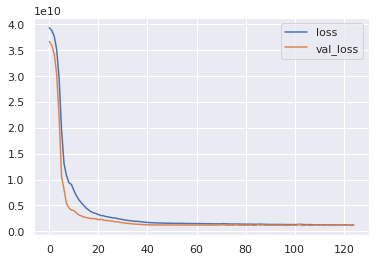

In [35]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(x=X,y=y,
          validation_split=0.1,
          batch_size=128,epochs=1000, callbacks=[early_stop])
losses = pd.DataFrame(model.history.history)
losses.plot()

Kode ini menunjukkan perhentian awal di sekitar 160 dan karena kita hanya menggunakan 90% dari data pelatihan, oleh karena itu kita akan menambahkan 10 sebagai perkiraan kasar dan mengambil jumlah epoch sebagai 170. Jadi kita akan mengatur ulang model dan melakukan pelatihan lagi pada model set data pelatihan yang lengkap

Epoch 1/170
12/12 [==============================] - 2s 22ms/step - loss: 39142731776.0000
Epoch 2/170
12/12 [==============================] - 0s 27ms/step - loss: 38680010752.0000
Epoch 3/170
12/12 [==============================] - 0s 31ms/step - loss: 37614125056.0000
Epoch 4/170
12/12 [==============================] - 0s 30ms/step - loss: 34988568576.0000
Epoch 5/170
12/12 [==============================] - 0s 28ms/step - loss: 28838998016.0000
Epoch 6/170
12/12 [==============================] - 1s 49ms/step - loss: 18150023168.0000
Epoch 7/170
12/12 [==============================] - 1s 47ms/step - loss: 11360230400.0000
Epoch 8/170
12/12 [==============================] - 0s 40ms/step - loss: 10234602496.0000
Epoch 9/170
12/12 [==============================] - 0s 22ms/step - loss: 9034759168.0000
Epoch 10/170
12/12 [==============================] - 0s 20ms/step - loss: 8082011648.0000
Epoch 11/170
12/12 [==============================] - 0s 19ms/step - loss: 7219408384.0000


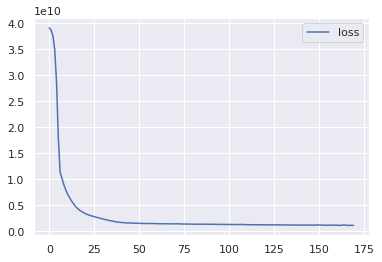

In [36]:
model = create_model() # Resetting the model.
history = model.fit(x=X,y=y,
          batch_size=128,epochs=170)
losses = pd.DataFrame(model.history.history)
losses.plot()

# Prediksi dan Evaluasi

Kita sekarang akan menjalankan model terhadap dataset pengujian. Tetapi sebelum itu kita perlu menskalakan data pengujian dengan cara yang sama seperti yang kita lakukan untuk data pelatihan dan untuk itu, kita akan kembali menggunakan fungsi StandardScaler dari Sklearn

In [49]:
X_test = scale.transform(test) # Scaling the testing data.
result = model.predict(X_test) # Prediction using model
result = pd.DataFrame(result,columns=['SalePrice']) # Dataframe
result['Id'] = test['Id'] # Adding ID to our result dataframe.
result = result[['Id','SalePrice']]
result.head()

,Id,SalePrice
0,1461,51.339394
1,1462,35.059734
2,1463,2001.645142
3,1464,3327.788330
4,1465,2786.517334
